In [26]:
# import packages
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
from SimPEG import maps
from SimPEG.electromagnetics import frequency_domain as fdem
from SimPEG.utils import plot_1d_layer_model 

from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
)

from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz

from discretize import TreeMesh

# 3D

## Define FDEM Survey

In [4]:
# 3x3 grid of transmitters with 1 receiver each
grid_spacing = 1.0 / 3  # Spacing of transmitters in x and y directions
offset = 0.1  # 10 cm inter-coil distance
src_z = 0.1  # Transmitters located at z = 10cm 
orientation = "z"  # z-oriented dipole for co-planar loops

# Create grid of transmitter locations
x_positions = np.linspace(-0.5, 0.5, 3)  
y_positions = np.linspace(-0.5, 0.5, 3) 

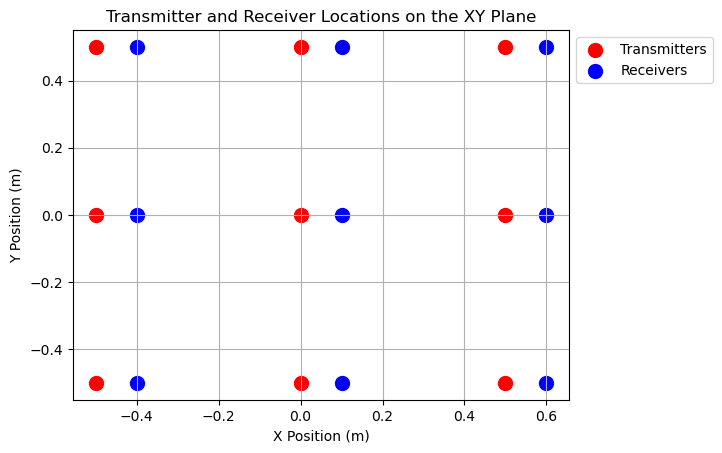

In [18]:
# Create lists to store positions of transmitters and receivers
transmitter_locs = []
receiver_locs = []

# Populate transmitter and receiver positions
for x in x_positions:
    for y in y_positions:
        transmitter_loc = [x, y]
        receiver_loc = [x + offset, y]  # Receiver is offset in x-direction

        transmitter_locs.append(transmitter_loc)
        receiver_locs.append(receiver_loc)


plt.scatter(np.array(transmitter_locs)[:, 0], np.array(transmitter_locs)[:, 1], color='r', label='Transmitters', s=100)
plt.scatter(np.array(receiver_locs)[:, 0], np.array(receiver_locs)[:, 1], color='b', label='Receivers', s=100)
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Transmitter and Receiver Locations on the XY Plane')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.show()

### 3D Survey

In [ ]:
freq = 1000

# Create the source list with corresponding receivers
source_list = []
for x in x_positions:
    for y in y_positions:
        src_loc = np.array([x, y, src_z])  # Position of the transmitter

        # Receiver location offset by 0.002 m in x direction
        rx_loc = src_loc + np.array([offset, 0.0, 0.0])  

        # Define real and imaginary receiver components
        rx_real = fdem.Rx.PointMagneticFluxDensitySecondary(
            locations=[rx_loc], orientation=orientation, component="real"
        )
        rx_imag = fdem.Rx.PointMagneticFluxDensitySecondary(
            locations=[rx_loc], orientation=orientation, component="imag"
        )

        # Create magnetic dipole source
        src = fdem.Src.MagDipole(
            receiver_list=[rx_real, rx_imag],
            location=src_loc,
            orientation=orientation,
            frequency=freq,
        )

        source_list.append(src)

# Create the survey and problem objects
# survey = FDEM.Survey(source_list)
# prob = FDEM.Simulation3DMagneticFluxDensity(
#     mesh, survey=survey, sigmaMap=mapping, solver=Solver
# )

## UXO Model with Octo 3D Mesh

### Define Topography

In [19]:
xx, yy = np.meshgrid(np.linspace(-1, 1, 51), np.linspace(-1, 1, 51))
zz = np.zeros(np.shape(xx))
topo_xyz = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

In [55]:
receiver_locations = np.hstack([np.array(receiver_locs), np.full((np.array(receiver_locs).shape[0], 1), src_z)])
dh = 0.01  # base cell width
dom_width = 0.5 # domain width
nbc = 2 ** int(np.round(np.log(dom_width / dh) / np.log(2.0)))  # num. base cells

# Define the base mesh
h = [(dh, nbc)]
mesh = TreeMesh([h, h, h], x0="CCC")

# Mesh refinement based on topography
mesh = refine_tree_xyz(
    mesh, topo_xyz, octree_levels=[0, 0, 0, 1], method="surface", finalize=False
)

# Mesh refinement near transmitters and receivers
# mesh = refine_tree_xyz(
#     mesh, receiver_locations, octree_levels=[2, 6], method="radial", finalize=False
# )

# Refine core mesh region
block_refine_xyz = np.array([[0.0, 0.0, -0.1]])  # Center of the high-conductive block at z = -0.4
mesh = refine_tree_xyz(
    mesh, block_refine_xyz, octree_levels=[2, 4], method="radial", finalize=False
)

# Finalize the mesh after all refinements
mesh.finalize()

C:\Users\sabri\AppData\Local\Temp\ipykernel_31052\165944055.py:11: DeprecationWarning: The surface option is deprecated as of `0.9.0` please update your code to use the `TreeMesh.refine_surface` functionality. It will be removed in a future version of discretize.
  mesh = refine_tree_xyz(
C:\Users\sabri\AppData\Local\Temp\ipykernel_31052\165944055.py:22: DeprecationWarning: The radial option is deprecated as of `0.9.0` please update your code to use the `TreeMesh.refine_points` functionality. It will be removed in a future version of discretize.
  mesh = refine_tree_xyz(


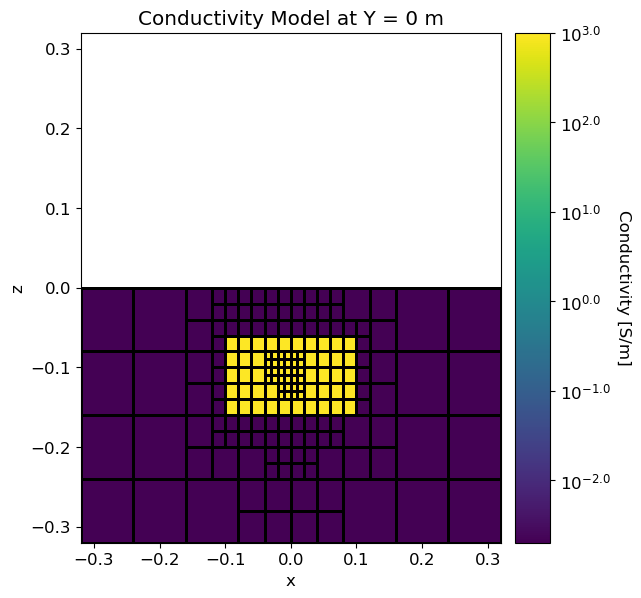

In [58]:
# Conductivity in S/m
air_conductivity = 1e-8
background_conductivity = 2e-3
block_conductivity = 1000

# Active cells are cells below the surface.
ind_active = active_from_xyz(mesh, topo_xyz)
model_map = maps.InjectActiveCells(mesh, ind_active, air_conductivity)

# Define the model with the block moved down between z = -0.6 and z = -0.2
model = background_conductivity * np.ones(ind_active.sum())
ind_block = (
    (mesh.gridCC[ind_active, 0] < 0.1)
    & (mesh.gridCC[ind_active, 0] > -0.1)
    & (mesh.gridCC[ind_active, 1] < 0.1)
    & (mesh.gridCC[ind_active, 1] > -0.1)
    & (mesh.gridCC[ind_active, 2] > -0.15)  # Adjusted z-range
    & (mesh.gridCC[ind_active, 2] < -0.05)  # Adjusted z-range
)
model[ind_block] = block_conductivity

# Plot log-conductivity model
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 6))

log_model = np.log10(model)

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.13, 0.1, 0.6, 0.85])
mesh.plot_slice(
    plotting_map * log_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.h[0].size / 2),
    grid=True,
    clim=(np.min(log_model), np.max(log_model)),
)
ax1.set_title("Conductivity Model at Y = 0 m")

ax2 = fig.add_axes([0.75, 0.1, 0.05, 0.85])
norm = mpl.colors.Normalize(vmin=np.min(log_model), vmax=np.max(log_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", format="$10^{%.1f}$"
)
cbar.set_label("Conductivity [S/m]", rotation=270, labelpad=15, size=12)